<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module1-rnn-and-lstm/LS_DS17_431_RNN_and_LSTM_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

* In the above diagram the path from input sequence of Xt-1, X, Xt+1 to purple lstm cells and to pink output neurons are all parallel (the vertical path in diagram) while lstm cells they do interact with each other in series manner (the horizental path). The horizental path could be bi-directional

In [1]:
# Vanishing gradients similar to vanishing the history of sequence in future predictions
0.0001 ** 1000

0.0

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

## Steps for text setiment classification:
* Read 25K imbd reviews, with a bag of 20K words as our dictionary of words >> `x_train`
* each word is represented by its relative count in the entire dataset as its integer representation
* use sequence.pad_sequences to fix the size of each review to 80 words
* In building the model use tf.keras.layers.Embedding layer to learn the spacial location of a dense vector of size `128` for each word in 20K dictionary in the context of all the reviews.
* Use LSTM layer to build up the model and train it based on the binary sentiment in y label

In [39]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

""" max_features is number of the most frequent words 
collected in the bag of words. The associated number to 
each word refers to the count of that word in the dataset.
"""
max_features = 20000

# desired number of words per review
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train.shape, 'train sequences')
print(len(x_test), 'test sequences')
# 25000 reviews

Loading data...
(25000,) train sequences
25000 test sequences


In [3]:
len(x_train[0])

218

In [4]:
# each review is a list of word ids from 20K bag of words. 
# The word id is the total count of the word in the entire dataset.
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [5]:
# Prep-padding shape
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (25000,)
x_test shape:  (25000,)


In [40]:
import pandas as pd
# repeated words in each review
pd.Series(x_train[0]).value_counts()

4       15
16      11
5        9
12       6
22       6
        ..
92       1
224      1
100      1
3941     1
98       1
Length: 123, dtype: int64

In [7]:
[len(x) for x in x_train[:10]]  # num of words from bag of 20K words in first ten reviews

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

In [8]:
# 5th review is short
x_train[5]

[1,
 778,
 128,
 74,
 12,
 630,
 163,
 15,
 4,
 1766,
 7982,
 1051,
 2,
 32,
 85,
 156,
 45,
 40,
 148,
 139,
 121,
 664,
 665,
 10,
 10,
 1361,
 173,
 4,
 749,
 2,
 16,
 3804,
 8,
 4,
 226,
 65,
 12,
 43,
 127,
 24,
 15344,
 10,
 10]

In [41]:
print('Pad Sequences (samples x time)')
#.pad_sequence method truncates or pads from the beginning
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [10]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [11]:
x_train[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,   778,   128,    74,    12,   630,   163,    15,
           4,  1766,  7982,  1051,     2,    32,    85,   156,    45,
          40,   148,   139,   121,   664,   665,    10,    10,  1361,
         173,     4,   749,     2,    16,  3804,     8,     4,   226,
          65,    12,    43,   127,    24, 15344,    10,    10],
      dtype=int32)

In [12]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

### 1. Word Embedding
A word embedding is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.

The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

The position of a word in the learned vector space is referred to as its embedding.

Two popular examples of methods of learning word embeddings from text include:

Word2Vec.
GloVe.
In addition to these carefully designed methods, a word embedding can be learned as part of a deep learning model. This can be a slower approach, but tailors the model to a specific training dataset.*

### 2. Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data.

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:

It can be used alone to learn a word embedding that can be saved and used in another model later.
It can be used as part of a deep learning model where the embedding is learned along with the model itself.
It can be used to load a pre-trained word embedding model, a type of transfer learning.
The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

`input_dim`: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
`output_dim`: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
`input_length`: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [42]:
model = Sequential()
# we are predicting the imdb review sentiment (output size =1)

# convert 20K inputs to 20K dense vector of size 128 (2560K params)
# input_length is the same as time steps in one input. 
# input_dim is not the same as batch size and it's specific to embedding's size of dictionary
model.add(Embedding(input_dim= max_features, output_dim = 128, input_length=maxlen))

# alternatively: dinamically takes the input shape of 80
# model.add(Embedding(max_features, 128))


# not related to the above 128 embedding
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# in Output Shape column (Nona, None, 128) is (batch_size, #of input features(80), dense vector size(128))
# the shape with None is dynamic and can be inferred
# Yhe most left None in Shape column is the dynamic batch_size for all the layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 128)           2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [43]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=2, 
          validation_data=(x_test,y_test))

Epoch 1/2
782/782 [==============================] - 232s 297ms/step - loss: 0.4307 - accuracy: 0.7957 - val_loss: 0.3499 - val_accuracy: 0.8471
Epoch 2/2
782/782 [==============================] - 231s 295ms/step - loss: 0.2561 - accuracy: 0.8960 - val_loss: 0.4228 - val_accuracy: 0.8258


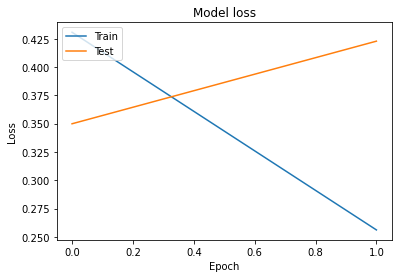

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [47]:
import numpy as np
"""Since it's a dynamic shape passing x_test[0] directly 
to .predict method will be considered 80 inputs not 1. 
Hence we either pass input slice or expand_dims with axis=0 to call the model"""
query = np.expand_dims(x_test[0],0)
print(model.predict(query))
print(model.predict(x_test[:1]))

# This is a wrong way and takes 80 input features as batch_size=80
print("missing the batch_size dimension:",len(model.predict(x_test[0])))   

# while the .predict method returns a np.ndarray, model(query) returns a tensor
model(query)


[[0.2411533]]
[[0.2411533]]
missing the batch_size dimension: 80


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2411533]], dtype=float32)>

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

## Steps to generate Text:
* Import articles. (`137` articles in 137 rows)
* create one giant text of all the articles >> `text`
* create a bag of unique characters with a corresponding unique integer >> `char, char_int, int_char`
* create a list of interleaved sequences of the same length characters, `40` represented with integer keys of the characters as input data and a list of corresponding integer represented next_character (the charcater after the sequence) as the target label >> `sequences, next_char`
> we can't train on this data as the next character prediction is a floating point that if it's rounded up or down, does not necessarily point to a predicted character as the integer representation of characters are random
* create multi dimensional boolean array for X: 
1. axis0: sequence number >> size `178374`
2. axis1: position of the character in sequence >> size `40`
3. axis2: identifier of the character in the bag of characters >> size `121`
* create a multi dimensional boolean array for Y:
1. axis0: sequence number >> size `178374`
2. axis1: identifier of the next_char in the bag of characters >> size `121`
* Build the LSTM model
* define a callback at the end of each epoch:
1. pick a random prompt (index) in the concatinated giant `text`
2. grab the 40 characters of the `text` as the query seed for character generation
3. convert the query seed to X.shape, i.e. (1, 40, 121) >> `x_pred`
4. get a y prediction from model after each epoch training, shape: (1, 121) >> `preds` an array of 121 floating values beytween 0 and 1, 1 being the strongest possibility for being the next_char
5. scale the values of y array to proba and take one draw from the array considering the value of proba. grab the selected char from draw and prints it as the next char after the sequence.
6. shift the input sequence to the right by 1 and predict the next char again >> get `400` characters iteratively
* This way we work with probability of all the characters as the next char instead of a floating number that is supposed to resemble one of the characters integer representation.

In [17]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import os

* The dataset consists of 136 new articles each article in one row

In [18]:
import pandas as pd

df = pd.read_json('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/wp_articles.json')
df.head(10)

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."
102,"The cause was cardiac arrest, said his longtim..."
103,LeCroy had waited to do this. He spent the ear...
104,"Updated January 9, 2017\n\nThis Terms of Sale ..."
105,"Updated June 4, 2018\n\nThis Terms of Sale gov..."
106,“Eventually I woke up and looked at the score ...


In [19]:
print(df.shape)
df.iloc[0,:]

(136, 1)


article    Contributing columnist\n\nThe House is on fire...
Name: 0, dtype: object

In [20]:
# data_files = os.listdir('./articles')  # If you're running locally

In [21]:
df['article'][0]

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

In [22]:
# # Read in Data

# data = []

# for file in data_files:
#     if file[-3:] == 'txt':
#         with open(f'./articles/{file}', 'r', encoding='utf-8') as f:
#             data.append(f.read())

In [23]:
# Convert pandas series into a ndarray
data = df['article'].values
print(data.shape, type(data))

(136,) <class 'numpy.ndarray'>


In [24]:
data[0]

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

### Bag of characters in the form of a dictionary with corresponding integers assigned
* Flatten the dataset into a giant string named text. 

In [25]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
#.join is a string method. joining each row of the ndarray to another row with a white space
# join iterables of data with a space
text = " ".join(data)

# Unique Characters, enumerate(set(text)) would produce random indexing at every run
chars = list(set(text))

# Lookup Tables 
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [26]:
set(text)

{'\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '©',
 '\xad',
 '·',
 '½',
 '×',
 'á',
 'ã',
 'è',
 'é',
 'ê',
 'í',
 'ñ',
 'ó',
 'ö',
 '–',
 '—',
 '―',
 '‘',
 '’',
 '“',
 '”',
 '•',
 '…',
 '\u2066',
 '\u2069',
 '⅓',
 '⅔',
 '●',
 '⭐',
 'ﬂ',
 '👻',
 '🗣',
 '🤔'}

In [27]:
print(len(text), type(text))
text[:50]

891910 <class 'str'>


'Contributing columnist\n\nThe House is on fire. And '

In [28]:
print(len(chars))

121


In [29]:
char_int[' ']

120

In [30]:
int_char[57]

'‘'

### Create same length sequences of the data
* sample the character sequence of 40 (length of sequence) consecutive characters every 5 character apart (step=5)
* reducing the step is similar to reducing the learning curve. 
* Increasing the length of each element of sequence is similar to increasing the batch_size

In [31]:
maxlen = 40
step = 5

# iterate through each character of the text to create a list 
# of ineteger numbers corresponding to each character
encoded = [char_int[c] for c in text]

sequences = [] # list of sequences each 40 char long
next_char = [] # One character for each sequence

for i in range(0, len(encoded) - maxlen, step):
    sequences.append(encoded[i : i + maxlen])
    # next_char refers to the character encoding right after the last character of the sequence in encoded list
    next_char.append(encoded[i + maxlen])
    
# The following two numbers are comparable and close
print('sequences: ', len(sequences), len(encoded)/step)

sequences:  178374 178382.0


In [32]:
# 40 is the next char after the first sequence. Also it's 40th char or 35th char in 2nd sequence
encoded[40], sequences[1][35], next_char[0]

(104, 104, 104)

In [33]:
# first char of the first article is C
print(int_char[encoded[0]])
encoded[:10]

C


[50, 77, 24, 48, 17, 13, 54, 117, 48, 13]

In [34]:
# One ineteger for each char
print(len(text), len(encoded))

891910 891910


In [35]:
# each sequence is 40 in length
print(len(sequences[0]), sequences[0])

40 [50, 77, 24, 48, 17, 13, 54, 117, 48, 13, 24, 95, 120, 72, 77, 37, 117, 34, 24, 13, 4, 48, 87, 87, 45, 7, 112, 120, 2, 77, 117, 4, 112, 120, 13, 4, 120, 77, 24, 120]


#### Create X and y
* Save the sequence number, character codes in each sequence and their location in each sequence in a boolian matrix
* Save the next character code after each sequence as an index pointer in a boolian matrix



In [36]:
# Create x & y

# Padding! initialize everything with False
x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)
test = []
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        # x[sequence#[0:137], char index in sequence[0:40], char encoded value[0:121]]
        # in the last dimension of x only 40 out of 121 will be True
        # 1 is stored as boolean type
        x[i,t,char] = 1
        test.append((i,t,char))
    # y[sequence, next character after sequence in embeded]   
    y[i, next_char[i]] = 1

In [37]:
# each sequence is on one row of axis=0, and will have boolean value(T/F)
# (sequence#_index, char_loc_index, char_code_index)
x.shape

(178374, 40, 121)

In [38]:
# (sequence#_index, char_code_index)
y.shape

(178374, 121)

In [39]:
# i is a tuple of indices that is for each character of each sequence in the flattened text
# first 5 characters of the first sequence
for i in test[:5]:
  print(x[i])
test[-5:]

True
True
True
True
True


[(178373, 35, 112),
 (178373, 36, 112),
 (178373, 37, 120),
 (178373, 38, 29),
 (178373, 39, 112)]

In [40]:
# build the model: a single LSTM
# x is the input sequence
model = Sequential()

"""number of rows does not need to be defined in 
input_shape as it's similar to batch size and it's dynamic
"""
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# y is the next character after the sequence
model.add(Dense(units=len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

* n=input dimension=len(chars)=121, maxlen says that only 40 of the 121 inputs are True

* m=# of lstm in layer, # paramters = 4*(n+m+1)*m
* output parameters = (128 parallel lstm + 1 bias)* 121 (character set or output)

In [41]:
4*(121+128+1)*128, (128+1)*121

(128000, 15609)

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               128000    
_________________________________________________________________
dense_1 (Dense)              (None, 121)               15609     
Total params: 143,609
Trainable params: 143,609
Non-trainable params: 0
_________________________________________________________________


In [43]:
def sample(preds):
    """
    It normalizes the array of preds to proba (with their sum equal to 1)
    Then it picks the index of the first maximum based on a random draw with the proba array weight
    """
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    
    # Null operation
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    
    # Normalize to the sum of one for the array of probabilities
    # exp_preds=preds is an array
    preds = exp_preds / np.sum(exp_preds)
    
    #multinomial(# of experiments, list of probability of each outcome, number of output repititions)
    # len(probas)=len(preds): showing how many times each possibility was selected
    probas = np.random.multinomial(1, preds, 1)   #ex/ probas=[0,0,1,0,0]
    
    # Returns the indices of the maximum values along an axis.
    return np.argmax(probas)

In [44]:
np.random.multinomial(1, [1/3]*3, 2)
ss = np.random.multinomial(1, [1/6, 1/3, 1/2], 1)
print(ss)
np.argmax(ss)

[[0 1 0]]


1

In [55]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    # Random prompt in order to grab a 40 consecutive character sample as the seed
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        # 400 is the length of generated text
        # create a quary sequence:
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        # Predict the next character after the sequence
        # preds is an array of length 121 
        # with numbers between 0 and 1 
        #corresponding to the strength of the prediction of each of 121 characters
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        # update the seed by moving one character forward
        sentence = sentence[1:] + next_char
        generated += next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print("\n**********\n", generated)
    print()
    print("\n\nlast character of this epoch preds:\n", len(preds), type(preds))
    print(preds)

# After each epoch generates a brand new 400 characters out of a 40 character seed
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [56]:
# fit the models
model.fit(x, y,
          batch_size=32,
          epochs=2,
          callbacks=[print_callback])

Epoch 1/2
5565/5575 [============================>.] - ETA: 0s - loss: 1.7404
----- Generating text after Epoch: 0
----- Generating with seed: "a Super Bowl hangover. They’re more conc"
a Super Bowl hangover. They’re more concreatly to shople that the ins “all factmyy, you have and so excepteds to state encearh empirlatical artimoss opan and just that hose which Elambain Dalolins Biless sny Asloa and Ukirigary Pott only presidents: known of desiwn had on the thetterves witn nises is who sag to aly not back for at the iss conflenings surges foriage that extitial Kassingly wabrist, and Trump stagomed afferent after a fac
**********
 a Super Bowl hangover. They’re more concreatly to shople that the ins “all factmyy, you have and so excepteds to state encearh empirlatical artimoss opan and just that hose which Elambain Dalolins Biless sny Asloa and Ukirigary Pott only presidents: known of desiwn had on the thetterves witn nises is who sag to aly not back for at the iss conflenings surges f

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 